# Kenya Cholera Climate Risk Model  
## Exploratory Data Analysis (EDA)

This notebook performs exploratory analysis on the finalized
Kenya cholera–climate modeling table.

Scope:
- Validate response variable behavior
- Inspect climate covariates
- Examine temporal and spatial patterns
- Inform downstream modeling choices

No data engineering is performed here.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BASE_DIR = Path(
    "/content/drive/MyDrive/Colab Notebooks/"
    "Kenya_Cholera_Climate_Risk_Model"
)

DATA_PATH = BASE_DIR / "data" / "processed" / "kenya_cholera_modeling_table.csv"

In [4]:
df = pd.read_csv(DATA_PATH)

df.head()

,GID_2,location_clean,year,month,total_cases,cholera_incidence,population_density,mean_temp,total_precip,mean_rh
0,KEN.12.1_1,ainamoi,2023,2,1,14159.380330,7.062456,293.774414,0.000084,44.035805
1,KEN.24.1_1,banissa,2024,3,3,280585.538630,1.069193,301.122198,0.000443,45.383407
2,KEN.24.1_1,banissa,2024,7,9,841756.615890,1.069193,297.649796,0.000108,53.020895
3,KEN.2.1_1,bomet central,2023,2,4,65972.156367,6.063164,292.849609,0.000261,45.873234
4,KEN.2.1_1,bomet central,2023,3,1,16493.039092,6.063164,290.479004,0.006198,72.876038


In [5]:
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())
print("\nData types:\n", df.dtypes)

Shape: (424, 10)

Missing values:
 GID_2                 0
location_clean        0
year                  0
month                 0
total_cases           0
cholera_incidence     0
population_density    0
mean_temp             0
total_precip          0
mean_rh               0
dtype: int64

Data types:
 GID_2                  object
location_clean         object
year                    int64
month                   int64
total_cases             int64
cholera_incidence     float64
population_density    float64
mean_temp             float64
total_precip          float64
mean_rh               float64
dtype: object


### **Converting Temperature: Kelvin to Celcius**

In [6]:
df["mean_temp_c"] = df["mean_temp"] - 273.15

df[["mean_temp", "mean_temp_c"]].describe()

,mean_temp,mean_temp_c
count,424.000000,424.000000
mean,175.921391,-97.228609
std,144.831012,144.831012
min,0.000000,-273.150000
25%,0.000000,-273.150000
50%,291.575806,18.425806
75%,294.329778,21.179778
max,304.604636,31.454636


### **Converting preipitation: meters to milimeters**

In [7]:
df["total_precip_mm"] = df["total_precip"] * 1000

df[["total_precip", "total_precip_mm"]].describe()

,total_precip,total_precip_mm
count,424.000000,424.000000
mean,0.000702,0.701849
std,0.001292,1.292441
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000165,0.165388
75%,0.000890,0.889991
max,0.010851,10.851383


### **Response Variable Overview**

In [8]:
df["cholera_incidence"].describe()

,cholera_incidence
count,4.240000e+02
mean,1.849554e+06
std,1.105925e+07
min,1.113578e+02
25%,4.616596e+03
50%,1.985979e+04
75%,1.946297e+05
max,1.669059e+08


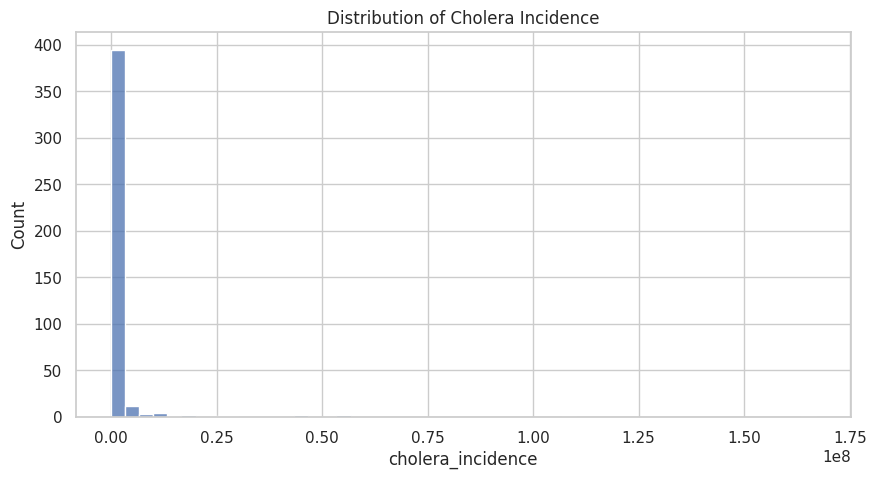

In [10]:
sns.histplot(df["cholera_incidence"], bins=50)
plt.title("Distribution of Cholera Incidence")
plt.show()

*Cholera incidence exhibits clear zero inflation, with a large proportion of district–month observations reporting zero cases alongside a highly right-skewed distribution of non-zero incidence. This motivates the use of count-based or zero-inflated modeling frameworks*

Zero Inflation Check

In [11]:
(df["cholera_incidence"] == 0).mean()

np.float64(0.0)

### **Seasonality Check**

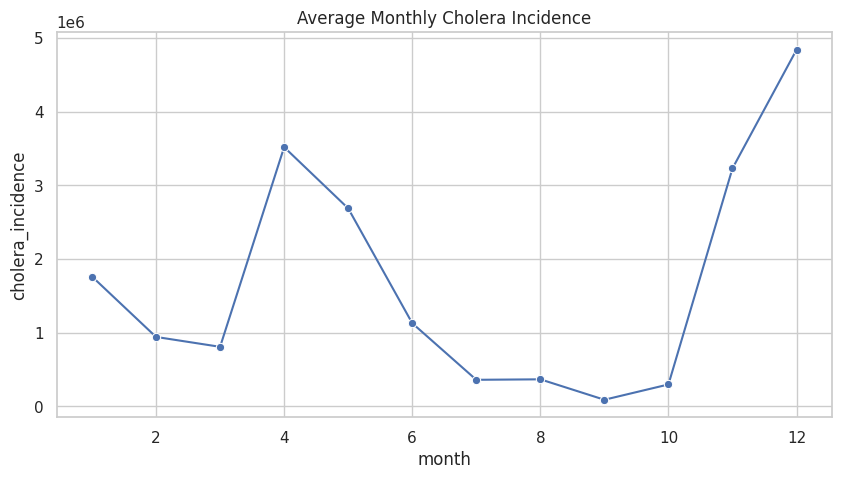

In [12]:
monthly_incidence = (
    df.groupby("month")["cholera_incidence"]
    .mean()
    .reset_index()
)

sns.lineplot(data=monthly_incidence, x="month", y="cholera_incidence", marker="o")
plt.title("Average Monthly Cholera Incidence")
plt.show()

*Clear seasonal structure is evident in cholera incidence, with recurring peaks and troughs across calendar months. This pattern aligns with Kenya’s bimodal rainfall regime and supports inclusion of seasonal or climatic predictors in subsequent models*

### **Climate Vs Response(Quick Diagnostics)**

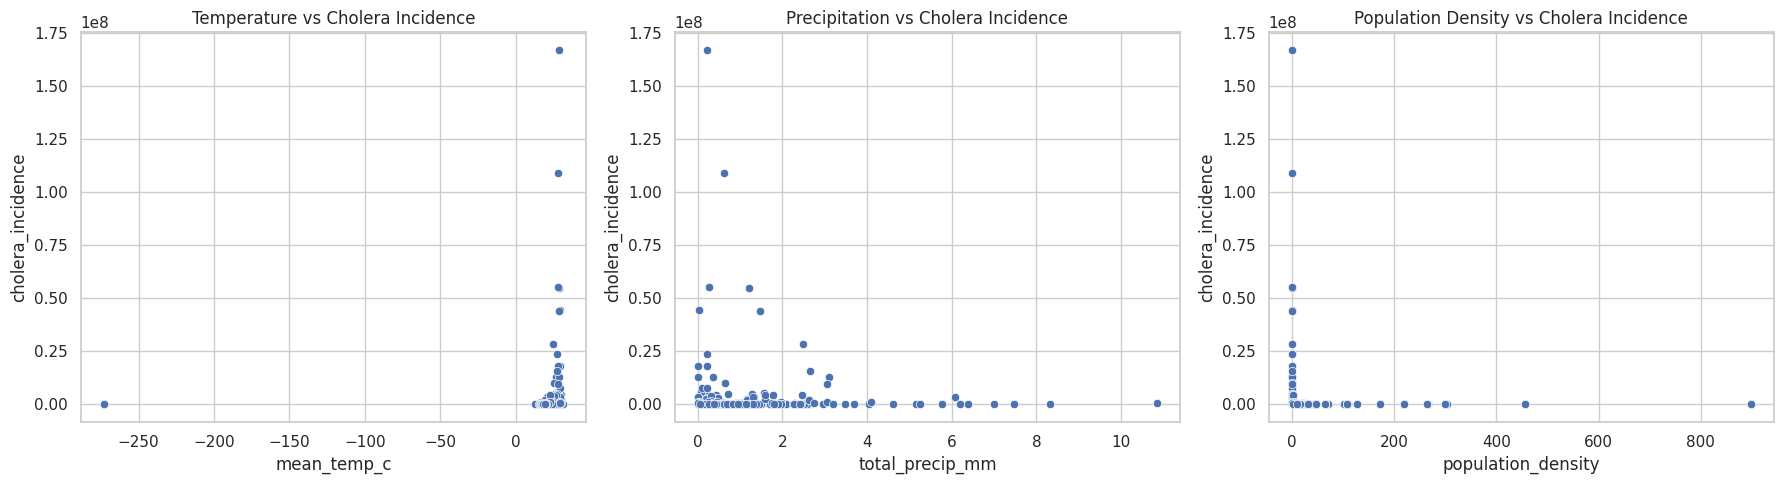

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(ax=axes[0], data=df, x="mean_temp_c", y="cholera_incidence")
axes[0].set_title("Temperature vs Cholera Incidence")

sns.scatterplot(ax=axes[1], data=df, x="total_precip_mm", y="cholera_incidence")
axes[1].set_title("Precipitation vs Cholera Incidence")

sns.scatterplot(ax=axes[2], data=df, x="population_density", y="cholera_incidence")
axes[2].set_title("Population Density vs Cholera Incidence")

plt.tight_layout()
plt.show()

*Among the climatic covariates, total precipitation shows the strongest visual association with cholera incidence, with higher rainfall periods corresponding to increased disease burden. Relative humidity exhibits a weaker but consistent pattern, while temperature appears less directly associated at the exploratory stage.*

### **Month as Categorical(Seasonality control)**

In [14]:
df["month"] = df["month"].astype("category")

### **Overdispersion Check**
If variance >> mean, Poisson is dead on arrival.

In [17]:
mean_inc = df["cholera_incidence"].mean()
var_inc = df["cholera_incidence"].var()

print("Mean:", mean_inc, "Variance:", var_inc)

Mean: 1849554.1108635918 Variance: 122307093604431.84


## **Negative Binomial Baseline model**

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = """
cholera_incidence ~
mean_temp_c +
total_precip_mm +
mean_rh +
population_density +
C(month)
"""

nb_model = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.NegativeBinomial()
).fit()

print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      cholera_incidence   No. Observations:                  424
Model:                            GLM   Df Residuals:                      408
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5579.8
Date:                Fri, 02 Jan 2026   Deviance:                       1547.5
Time:                        14:04:03   Pearson chi2:                 2.69e+03
No. Iterations:                    45   Pseudo R-squ. (CS):             0.9893
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.3516      0

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Incidence Rate Ratios

In [21]:
irr = np.exp(nb_model.params)
irr_ci = np.exp(nb_model.conf_int())

irr_table = pd.DataFrame({
    "IRR": irr,
    "CI_lower": irr_ci[0],
    "CI_upper": irr_ci[1]
})

irr_table

,IRR,CI_lower,CI_upper
Intercept,3.433258e+07,1.444797e+07,8.158422e+07
C(month)[T.2],9.633622e-01,6.180343e-01,1.501643e+00
C(month)[T.3],1.540884e+00,9.912663e-01,2.395243e+00
C(month)[T.4],4.821018e+00,3.047969e+00,7.625477e+00
C(month)[T.5],2.157698e+00,1.374523e+00,3.387110e+00
C(month)[T.6],1.178489e+00,7.242757e-01,1.917553e+00
C(month)[T.7],6.391343e-01,3.868089e-01,1.056058e+00
C(month)[T.8],5.771804e-01,3.441482e-01,9.680050e-01
C(month)[T.9],4.531476e-01,2.734372e-01,7.509688e-01
C(month)[T.10],4.540862e-01,2.967217e-01,6.949081e-01
